In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import pickle
from keras.utils.np_utils import to_categorical
import keras_tuner as kt
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [11]:
!pip install scikit-learn==1.1.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 59.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.2 MB/s eta 0:00:00


In [2]:
#important landmarks
landmarks = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "RIGHT_ELBOW",
    "LEFT_ELBOW",
    "RIGHT_WRIST",
    "LEFT_WRIST",
    "LEFT_HIP",
    "RIGHT_HIP",
]



HEADERS = ["label"]

for lm in landmarks:
    HEADERS += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [3]:
print(HEADERS)

['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']


In [4]:
def describe_dataset(dataset_path: str):


    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

In [5]:
# load dataset
df = describe_dataset("/content/drive/MyDrive/train_trest_bc/bc/train.csv")

# Categorizing label
df.loc[df["label"] == "C", "label"] = 0
df.loc[df["label"] == "L", "label"] = 1

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']
Number of rows: 15372 
Number of columns: 37

Labels: 
C    8238
L    7134
Name: label, dtype: int64

Missing values: False

Duplicate Rows : 0


In [6]:
with open("/content/drive/MyDrive/train_trest_bc/bc/input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)

In [7]:
# Standard Scaling of features
x = df.drop("label", axis = 1)
x = pd.DataFrame(sc.transform(x))

y = df["label"]

# # Converting prediction to categorical
y_cat = to_categorical(y)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x.values, y_cat, test_size=0.2, random_state=1234)

In [9]:
def describe_model(model):
    '''
    Describe Model architecture
    '''
    print(f"Describe models architecture")
    for i, layer in enumerate(model.layers):
        number_of_units = layer.units if hasattr(layer, 'units') else 0

        if hasattr(layer, "activation"):
            print(f"Layer-{i + 1}: {number_of_units} units, func: ", layer.activation)
        else:
            print(f"Layer-{i + 1}: {number_of_units} units, func: None")

In [10]:
def get_best_model(tuner):
    '''
    Describe and return the best model found from keras tuner
    '''
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)

    describe_model(best_model)

    print("\nOther params:")
    ignore_params = ["tuner", "activation", "layer", "epoch"]
    for param, value in best_hps.values.items():
        if not any(word in param for word in ignore_params):
            print(f"{param}: {value}")

    return best_model

In [11]:
stop_early = EarlyStopping(monitor='val_loss', patience=3)

# Final Results
final_models = {}

In [12]:
def model_builder(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(36, input_dim = 36, activation = "relu"))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_layer_1 = hp.Int('layer_1', min_value=32, max_value=512, step=32)
    hp_layer_2 = hp.Int('layer_2', min_value=32, max_value=512, step=32)
    hp_layer_3 = hp.Int('layer_3', min_value=32, max_value=512, step=32)
    hp_layer_4 = hp.Int('layer_4', min_value=32, max_value=512, step=32)
    hp_layer_5 = hp.Int('layer_5', min_value=32, max_value=512, step=32)
    hp_layer_6 = hp.Int('layer_6', min_value=32, max_value=512, step=32)
    hp_layer_7 = hp.Int('layer_7', min_value=32, max_value=512, step=32)
    hp_layer_8 = hp.Int('layer_8', min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_3, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_4, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_5, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_6, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_7, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_8, activation=hp_activation))
    model.add(tf.keras.layers.Dense(2, activation = "softmax"))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [13]:
tuner_dl = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo_6'
)
tuner_dl.search(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Trial 30 Complete [00h 00m 38s]
val_accuracy: 0.9954471588134766

Best val_accuracy So Far: 0.9980487823486328
Total elapsed time: 00h 07m 48s


In [14]:
model_dl = get_best_model(tuner_dl)
history=model_dl.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), callbacks=[stop_early])

Describe models architecture
Layer-1: 36 units, func:  <function relu at 0x7fad32dfecb0>
Layer-2: 160 units, func:  <function relu at 0x7fad32dfecb0>
Layer-3: 160 units, func:  <function relu at 0x7fad32dfecb0>
Layer-4: 128 units, func:  <function relu at 0x7fad32dfecb0>
Layer-5: 320 units, func:  <function relu at 0x7fad32dfecb0>
Layer-6: 320 units, func:  <function relu at 0x7fad32dfecb0>
Layer-7: 288 units, func:  <function relu at 0x7fad32dfecb0>
Layer-8: 128 units, func:  <function relu at 0x7fad32dfecb0>
Layer-9: 64 units, func:  <function relu at 0x7fad32dfecb0>
Layer-10: 2 units, func:  <function softmax at 0x7fad32dfe290>

Other params:
learning_rate: 0.0001
Epoch 1/100
1230/1230 [==============================] - 7s 5ms/step - loss: 0.0856 - accuracy: 0.9741 - val_loss: 0.0175 - val_accuracy: 0.9948
Epoch 2/100
1230/1230 [==============================] - 5s 4ms/step - loss: 0.0236 - accuracy: 0.9937 - val_loss: 0.0143 - val_accuracy: 0.9964
Epoch 3/100
1230/1230 [===========

In [15]:
describe_model(model_dl)

Describe models architecture
Layer-1: 36 units, func:  <function relu at 0x7fad32dfecb0>
Layer-2: 160 units, func:  <function relu at 0x7fad32dfecb0>
Layer-3: 160 units, func:  <function relu at 0x7fad32dfecb0>
Layer-4: 128 units, func:  <function relu at 0x7fad32dfecb0>
Layer-5: 320 units, func:  <function relu at 0x7fad32dfecb0>
Layer-6: 320 units, func:  <function relu at 0x7fad32dfecb0>
Layer-7: 288 units, func:  <function relu at 0x7fad32dfecb0>
Layer-8: 128 units, func:  <function relu at 0x7fad32dfecb0>
Layer-9: 64 units, func:  <function relu at 0x7fad32dfecb0>
Layer-10: 2 units, func:  <function softmax at 0x7fad32dfe290>


In [16]:
evaluate = model_dl.evaluate(x=x_test,y=y_test)

97/97 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 0.9974


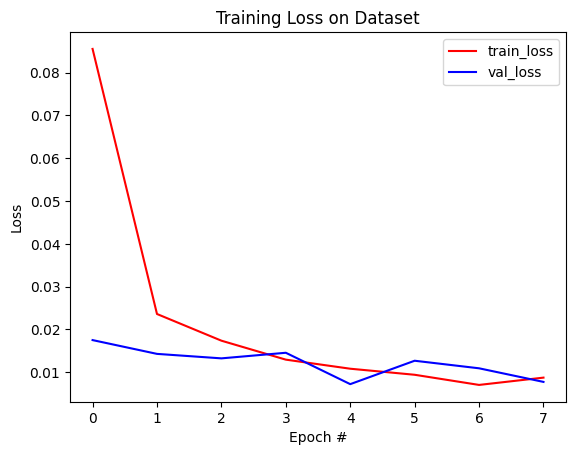

In [17]:
epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

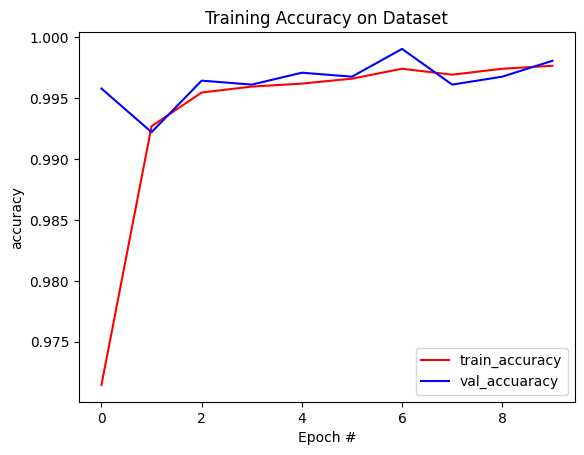

In [ ]:
epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['accuracy'], 'red', label = 'train_accuracy')
plt.plot(epoch, history.history['val_accuracy'], 'blue', label = 'val_accuaracy')
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("accuracy")
plt.legend()

In [21]:
model_dl.save("/content/drive/MyDrive/train_trest_bc/bc/model/")

In [22]:
saved_model_path = "/content/drive/MyDrive/train_trest_bc/bc/model/"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

# Convert to TFLite model
tflite_model = converter.convert()

In [24]:
tflite_model_path = "/content/drive/MyDrive/train_trest_bc/bc/tflitemodel2/bc_model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)